# This code is replication of basline for VietAI data set, multilabel pathology classification
https://www.kaggle.com/hmchuong/keras-baseline-model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("."))

# Any results you write to the current directory are saved as output.


['.config', 'sample_data']


In [2]:
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras as keras


from PIL import Image

# Check Eager Execution
tf.executing_eagerly() 

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/Viet_AI/Data')
print(os.listdir("."))

['train.csv', 'MLE_at_Epic_Software-SOLUTIONS.ipynb', 'U-net_TF2_retinal_image_segmentation_STARE.ipynb', 'U-net_binary_DB1.ipynb', 'resnet50.h5', 'my_model.h5', 'VietAI.hdf5', 'test', '.ipynb_checkpoints', 'train', 'logs', 'VietAI_multi-label.ipynb', 'mclass_data.npz', 'CNN_multi.h5', 'data.npz', 'VietAI_Tansfer_learning (1).ipynb', 'TF_30.h5', 'TF_conv_30.h5', 'VietAI_Tansfer_learning-conv.ipynb', 'LP_TF.npz', 'LP_TF_test.npz', 'TF.h5', 'VietAI_Tansfer_learning.ipynb', 'VietAI-visualize.ipynb', 'VietAI_multi_label-multi_class.ipynb', 'Viet_AI_LP_TF_noFalse_all_data.ipynb', 'TF_half_30.h5', 'LP_TF_half.npz', 'LP_TF_half_test.npz', 'VietAI-Label_propagate_TF_data_create.ipynb', 'new_train_data.npz', 'TF_1580_20.h5', 'VietAI-visualize-TF.ipynb', 'output', 'TF_all_20.h5', 'ipykernel_launcher.py_plot.png', 'Viet_AI_Results.gsheet', 'VietAI_Basline.ipynb']


In [5]:
data = pd.read_csv("train.csv")
data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [6]:
import skimage.io as io

In [7]:
img=io.imread('./train/train/f6228611d767.jpg')
np.shape(img)

(512, 512, 3)

In [8]:
print(data.shape)

(3435, 8)


In [9]:
Y=data.iloc[:,1:8].values
print(np.shape(Y))

(3435, 7)


In [10]:
def binary_converter(arr):
    total = 0
    for index, val in enumerate(reversed(arr)):
        total += (val * 2**index)
    return total

In [11]:
Y1=list()

for i in range(np.shape(Y)[0]):
    #print(i)
    label=binary_converter(Y[i])
    Y1.append(label)

In [12]:
vals=np.unique(Y1)
np.shape(vals)

(36,)

# Data Analysis

In [13]:
for label in data.columns[1:]:
    print("Distribution of", label)
    print(data[label].value_counts())

Distribution of opacity
0    1902
1    1533
Name: opacity, dtype: int64
Distribution of diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Distribution of glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64
Distribution of macular edema
0    2919
1     516
Name: macular edema, dtype: int64
Distribution of macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64
Distribution of retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64
Distribution of normal
0    2910
1     525
Name: normal, dtype: int64


# Apart from opacity, all other labels have 4:1, 5:1 ratio for labels 0:1

# Next analyze combination of data

In [14]:
LABELS = data.columns[1:]
def build_label(row):
    return ",".join([LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1])
        
data.apply(lambda x: build_label(x), axis=1).value_counts()

opacity                                                                  671
normal                                                                   525
glaucoma                                                                 327
macular degeneration                                                     299
opacity,macular degeneration                                             212
diabetic retinopathy                                                     212
opacity,diabetic retinopathy                                             186
retinal vascular occlusion                                               170
diabetic retinopathy,macular edema                                       162
opacity,diabetic retinopathy,macular edema                               154
opacity,glaucoma                                                         140
macular edema,retinal vascular occlusion                                  74
opacity,macular edema,retinal vascular occlusion                          62

In [15]:
LABELS

Index(['opacity', 'diabetic retinopathy', 'glaucoma', 'macular edema',
       'macular degeneration', 'retinal vascular occlusion', 'normal'],
      dtype='object')

# Next begin training

In [16]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [17]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 32                             
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 20         

In [18]:
def preprocessing_image(image):
    """
    Preprocess image after resize and augment data with ImageDataGenerator
    
    Parameters
    ----------
    image: numpy tensor with rank 3
        image to preprocessing
    
    Returns
    -------
    numpy tensor with rank 3
    """
    rotation_range=10.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
    #preprocessing_function=contrast_only,
    
    
    
    return image

In [19]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                             featurewise_center=True,
                                                             featurewise_std_normalization=True,
                                                             preprocessing_function=preprocessing_image)

In [20]:
test_datagen= keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                             featurewise_center=True,
                                                             featurewise_std_normalization=True)

In [21]:
def build_label_list(row):
    return [LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1]
        
train_data["label"] = train_data.apply(lambda x: build_label_list(x), axis=1)
val_data["label"] = val_data.apply(lambda x: build_label_list(x), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
print(train_data)

              filename  ...                                              label
2622  93fdb9253059.jpg  ...                             [diabetic retinopathy]
1263  7bfe29171658.jpg  ...  [opacity, macular edema, retinal vascular occl...
1659  308ba6309b27.jpg  ...                             [macular degeneration]
572   7148a621c41c.jpg  ...                    [opacity, macular degeneration]
2522  933b55337d90.jpg  ...                    [opacity, macular degeneration]
...                ...  ...                                                ...
1095  a6ab3b092111.jpg  ...     [opacity, diabetic retinopathy, macular edema]
1130  3b8080fb2d34.jpg  ...                                          [opacity]
1294  bfc041c9f3b4.jpg  ...                             [macular degeneration]
860   2d8f4e99fff0.jpg  ...                    [opacity, diabetic retinopathy]
3174  bd8fd3ece129.jpg  ...                                           [normal]

[2748 rows x 9 columns]


In [23]:
train_gen = train_datagen.flow_from_dataframe(dataframe=train_data, 
                                        directory="./train/train", 
                                        x_col="filename", 
                                        y_col="label",
                                        class_mode="categorical",
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                        batch_size=BATCH_SIZE)

Found 2748 validated image filenames belonging to 7 classes.


In [24]:
val_gen = test_datagen.flow_from_dataframe(dataframe=val_data, 
                                        directory="./train/train", 
                                        x_col="filename", 
                                        y_col="label",
                                        class_mode="categorical",
                                        shuffle=False,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                        batch_size=1)

Found 687 validated image filenames belonging to 7 classes.


# Define the model

In [25]:
base_model = keras.applications.InceptionV3(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                                    include_top=False,
                                    weights='imagenet')
base_model.trainable = True

model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(512, activation='relu'), #add another layer for visualization
  keras.layers.Dense(len(LABELS), activation='sigmoid')
])

# Print out model summary
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 22,855,463
Trainable params: 22,821,031
Non-trainable params: 34,432
_________________________________________________________________


In [26]:
import tensorflow.keras.backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
#Step 3: Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [28]:
#This code snippet helps if your computer has RTX 2070 GPU. If not then comment this cell.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [29]:
steps_per_epoch = 10 #train_gen.n // BATCH_SIZE
validation_steps = 10 #val_gen.n // BATCH_SIZE
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('VietAI.hdf5', monitor='loss',verbose=1, save_best_only=True)
    
model.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), loss='binary_crossentropy', metrics='accuracy')

history = model.fit(train_gen,steps_per_epoch=steps_per_epoch,epochs= MAX_EPOCHS,verbose=1,callbacks=[model_checkpoint,tensorboard_callback])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
10/10 [==============================] - 110s 9s/step - loss: 0.5533 - accuracy: 0.2872

Epoch 00001: loss improved from inf to 0.48908, saving model to VietAI.hdf5
Epoch 2/20
10/10 [==============================] - 83s 8s/step - loss: 0.4430 - accuracy: 0.3866

Epoch 00002: loss improved from 0.48908 to 0.44129, saving model to VietAI.hdf5
Epoch 3/20
10/10 [==============================] - 69s 7s/step - loss: 0.4400 - accuracy: 0.3347

Epoch 00003: loss did not improve from 0.44129
Epoch 4/20
10/10 [==============================] - 61s 6s/step - loss: 0.4189 - accuracy: 0.3251

Epoch 00004: loss improved from 0.44129 to 0.41364, saving model to VietAI.hdf5
Epoch 5/20
10/10 [==============================] - 58s 6s/step - loss: 0.4101 - accuracy: 0.3385

Epoch 00005: loss improved from 0.41364 to 0.40923, saving model to VietAI.hdf5
Epoch 6/20
10/10 [==============================] - 50s 5s/step - loss: 0.4172 - accuracy: 0.3178

Epoch 00006: loss improved from 0.40923 to

In [30]:
print(history.history)

{'loss': [0.4890759587287903, 0.44129037857055664, 0.4433651268482208, 0.41364485025405884, 0.4092329442501068, 0.3924838900566101, 0.36222437024116516, 0.3736587166786194, 0.3376171886920929, 0.33430710434913635, 0.3310147523880005, 0.3360389471054077, 0.3461061120033264, 0.30967170000076294, 0.29928964376449585, 0.3082214295864105, 0.32672637701034546, 0.28561118245124817, 0.2620479464530945, 0.26053160429000854], 'accuracy': [0.29374998807907104, 0.35624998807907104, 0.33544304966926575, 0.3499999940395355, 0.35759493708610535, 0.36250001192092896, 0.4556961953639984, 0.421875, 0.4905063211917877, 0.5218750238418579, 0.5, 0.5379746556282043, 0.4437499940395355, 0.550000011920929, 0.559374988079071, 0.5375000238418579, 0.503125011920929, 0.5531250238418579, 0.643750011920929, 0.643750011920929]}


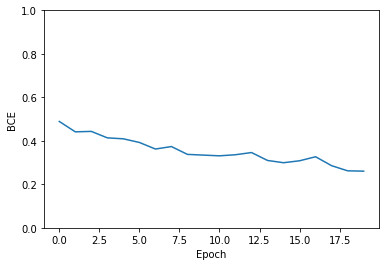

In [31]:
# Plot history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('BCE')
plt.ylim([0, 1])
plt.show()

In [32]:
#model.save('my_model.h5')

In [33]:
dependencies = {
    'f1': f1
}

In [34]:
from tensorflow.keras.models import load_model

mod=load_model('my_model.h5',custom_objects=dependencies)

In [35]:
# Try focal loss for 80/20 split data
# focal loss with multi label
def focal_loss(classes_num, gamma=2., alpha=.25, e=0.1):
    # classes_num contains sample number of each classes
    def focal_loss_fixed(target_tensor, prediction_tensor):
        '''
        prediction_tensor is the output tensor with shape [None, 100], where 100 is the number of classes
        target_tensor is the label tensor, same shape as predcition_tensor
        '''
        import tensorflow as tf
        from tensorflow.python.ops import array_ops
        from keras import backend as K

        #1# get focal loss with no balanced weight which presented in paper function (4)
        zeros = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        one_minus_p = array_ops.where(tf.greater(target_tensor,zeros), target_tensor - prediction_tensor, zeros)
        FT = -1 * (one_minus_p ** gamma) * tf.log(tf.clip_by_value(prediction_tensor, 1e-8, 1.0))

        #2# get balanced weight alpha
        classes_weight = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)

        total_num = float(sum(classes_num))
        classes_w_t1 = [ total_num / ff for ff in classes_num ]
        sum_ = sum(classes_w_t1)
        classes_w_t2 = [ ff/sum_ for ff in classes_w_t1 ]   #scale
        classes_w_tensor = tf.convert_to_tensor(classes_w_t2, dtype=prediction_tensor.dtype)
        classes_weight += classes_w_tensor

        alpha = array_ops.where(tf.greater(target_tensor, zeros), classes_weight, zeros)

        #3# get balanced focal loss
        balanced_fl = alpha * FT
        balanced_fl = tf.reduce_mean(balanced_fl)

        #4# add other op to prevent overfit
        # reference : https://spaces.ac.cn/archives/4493
        nb_classes = len(classes_num)
        fianal_loss = (1-e) * balanced_fl + e * K.categorical_crossentropy(K.ones_like(prediction_tensor)/nb_classes, prediction_tensor)

        return fianal_loss
    return focal_loss_fixed

#model.compile(optimizer=SGD(lr=learning_rate, momentum=0.9), loss=[focal_loss(classes_num)], metrics=['accuracy'])

In [36]:
pred = model.predict_generator(val_gen, 80,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


80/80 [==============================] - 25s 293ms/step


Epoch 0
[0. 1. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


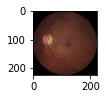

Epoch 1
[0. 0. 0. 1. 0. 0. 1.]


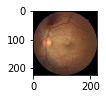

Epoch 2
[0. 0. 1. 0. 0. 0. 0.]


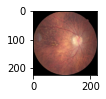

Epoch 3
[0. 0. 0. 0. 1. 0. 0.]


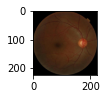

Epoch 4
[0. 0. 0. 1. 0. 1. 1.]


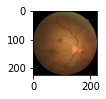

In [37]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in val_gen:
        #print(np.max(x_batch))
        for i in range(0, 1):
            plt.subplot(330+1 + i)
            plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
            print(y_batch[i])
        

        plt.show()
        
        break

In [38]:
for e in range(10):
    print('Epoch', e)
    for x_batch, y_batch in val_gen:
        pred = model.predict(x_batch, verbose=1)
        print(pred,y_batch)
        
        break

Epoch 0


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1/1 [==============================] - 1s 1s/step
[[0.49057513 0.02677384 0.04960263 0.08479933 0.00123486 0.7524141
  0.03520799]] [[0. 0. 0. 0. 0. 1. 0.]]
Epoch 1
1/1 [==============================] - 0s 28ms/step
[[8.2892383e-04 9.7983289e-01 1.0132414e-03 5.2415178e-04 2.0796966e-03
  2.2511643e-01 5.4684239e-03]] [[0. 1. 0. 0. 0. 0. 0.]]
Epoch 2
1/1 [==============================] - 0s 24ms/step
[[4.5610958e-01 2.6143133e-03 3.8602384e-04 5.4404363e-03 8.6296815e-01
  8.0400035e-03 6.1963424e-03]] [[0. 0. 0. 1. 0. 0. 1.]]
Epoch 3
1/1 [==============================] - 0s 27ms/step
[[0.7597991  0.01471016 0.08700618 0.24713866 0.00081438 0.6792034
  0.03770944]] [[0. 0. 1. 0. 0. 1. 0.]]
Epoch 4
1/1 [==============================] - 0s 26ms/step
[[1.0367398e-02 9.1492785e-03 1.7761464e-03 5.1697227e-04 9.8728460e-01
  5.3799013e-03 5.5612344e-03]] [[1. 0. 0. 0. 0. 0. 0.]]
Epoch 5
1/1 [==============================] - 0s 22ms/step
[[9.9593949e-01 2.4257312e-03 4.2434197e-04 3.023

In [39]:
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels
LABELS = list(LABELS)

def probs2label(probs):
    ''' Return real index following LABELS
    '''
    global LABELS, labels
    result = " ".join([str(LABELS.index(labels[idx])) for idx, prob in enumerate(probs) if prob > 0.5])
    print(result)
    return result

In [40]:
print(labels)

{0: 'diabetic retinopathy', 1: 'glaucoma', 2: 'macular degeneration', 3: 'macular edema', 4: 'normal', 5: 'opacity', 6: 'retinal vascular occlusion'}
